# Lab 2: Classification

### Machine Learning 1, September 2015

* The lab exercises should be made in groups of two, three or four people.
* The deadline is October 4th (Sunday) 23:59.
* Assignment should be sent to Philip Versteeg (p.j.j.p.versteeg@uva.nl). The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* For this notebook you need to answer a few theory questions, add them in the Markdown cell's below the question. Note: you can use Latex-style code in here.
* Focus on Part 1 the first week, and Part 2 the second week!
* You should write your code and answers below the questions in this IPython Notebook.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* If you have questions outside of the labs, post them on blackboard or email me.
* NOTE: Make sure we can run your notebook / scripts!

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [5]:
%matplotlib inline
import gzip, cPickle
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
rcParams['legend.loc'] = 'best'

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can load the data from `mnist.pkl.gz` we provided, using: 

In [6]:
def load_mnist():
    f = gzip.open('mnist.pkl.gz', 'rb')
    data = cPickle.load(f)
    f.close()
    return data

(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = load_mnist()

The tuples represent train, validation and test sets. The first element (`x_train`, `x_valid`, `x_test`) of each tuple is a $N \times M$ matrix, where $N$ is the number of datapoints and $M = 28^2 = 784$ is the dimensionality of the data. The second element (`t_train`, `t_valid`, `t_test`) of each tuple is the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


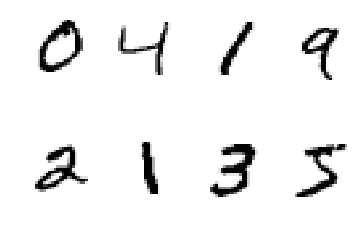

In [7]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    numrows = int(numdigits/numcols)
    for i in range(0, numdigits):
        plt.subplot(numrows, numcols, i)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.show()
    
plot_digits(x_train[0:8], numcols=4)

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_j \exp(\log q_j)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

Warning: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

##### Answer: 

$\dfrac{\partial \log Z}{\partial Z} = \dfrac{1}{Z}$

$\dfrac{\partial Z}{\partial \log q_j} = \dfrac{\partial \sum_k q_k}{\partial \log q_j} = \dfrac{\partial q_j}{\partial \log q_j} = \dfrac{\partial exp(\log q_j)}{\partial \log q_j} = exp(\log q_j)$

For $j = t^{(n)}$: $\delta_j^q = 1 - \dfrac{1}{Z}exp(\log q_j)$

For $j \neq t^{(n)}$: $\delta_j^q = -\dfrac{1}{Z}exp(\log q_j)$

$ \log q_j = \mathbf{w}_j^T \mathbf{x} = b_j + \sum_{i} W_{ij} x_i \Rightarrow \dfrac{\partial \log q_j}{\partial W_{ij}} = x_i \Rightarrow \dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \delta_j^q x_i$

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).


In [9]:
def logreg_gradient(x, t, w, b):
     log_q = w.transpose().dot(x)+b
     Z = np.sum(np.exp(log_q))
     delta= -np.exp(log_q)/Z
     delta[t]+=1
     grad_w = delta[np.newaxis].T.dot(x[np.newaxis]).T
     grad_b = delta
     return grad_w, grad_b

In [10]:
def init_weights(num_of_features, num_of_class):
    w = (np.random.random_sample((num_of_features, num_of_class)) - 0.5) * 0.001
    b = (np.random.random_sample(num_of_class) - 0.5) * 0.001
    return w, b

np.random.seed(0)
num_of_features = x_train.shape[1]
num_of_class = 10

In [11]:
# Test
w, b = init_weights(num_of_features, num_of_class)

random_item_id = np.random.randint(x_train.shape[0])
grad_w, grad_b = logreg_gradient(x_train[random_item_id], t_train[random_item_id], w, b)
print grad_w.shape, grad_b.shape

(784, 10) (10,)


### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters using a small learning rate (e.g. `1E-4`). Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [12]:
def sgd_iter(x_train, t_train, w, b,alpha=1E-4):
    ind = np.arange(len(t_train))
    np.random.shuffle(ind)

    for i in ind:
        grad_w,grad_b=logreg_gradient(x_train[i],t_train[i],w,b)
        w+=alpha*grad_w
        b+=alpha*grad_b

    return w,b

In [13]:
def compute_log_likelihood(x, t, w, b):
    log_q = x.dot(w) + b
    a = np.max(log_q, axis=1)
    log_Z = a + np.log(np.sum(np.exp((log_q.T - a).T)))
    #print log_Z
    log_likelihood = np.sum(np.array([log_q[index, value] for (index,), value in np.ndenumerate(t)]) - log_Z)
    return log_likelihood

In [14]:
# Test
w, b = init_weights(num_of_features, num_of_class)
print 'Likelihood:', compute_log_likelihood(x_train, t_train, w, b)
sgd_iter(x_train, t_train, w, b)
print 'Likelihood:', compute_log_likelihood(x_train, t_train, w, b)

print w.shape, b.shape

Likelihood: -656101.475887
Likelihood: -586028.559223
(784, 10) (10,)


## 1.2. Train

### 1.2.1 Train (10 points)
Perform a handful of training iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


In [8]:
def train_iterations(iters,w,b):
    l_val=[]
    l_tr=[]

    # default likelihoods
    l_tr.append(compute_log_likelihood(x_train,t_train,w,b))
    l_val.append(compute_log_likelihood(x_valid,t_valid,w,b))

    for i in range(2,iters+1):
       w, b = sgd_iter(x_train, t_train, w, b)
       l_tr.append(compute_log_likelihood(x_train,t_train,w,b))
       l_val.append(compute_log_likelihood(x_valid,t_valid,w,b))
    plt.plot(range(1,iters+1),l_val,'-',color='red',label='Validation set Likelihood')
    plt.plot(range(1,iters+1),l_tr,'-',color='blue', label='Training set Likelihood')
    plt.legend()
    plt.ylabel("Likelihood")
    plt.xlabel("Iterations")
    plt.show()
    return w

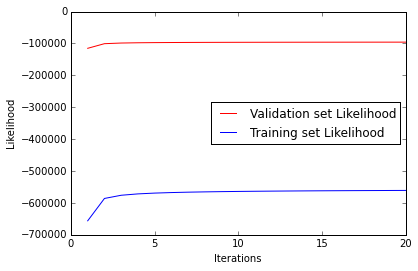

In [19]:
num_of_features = x_train.shape[1]
num_of_class = 10
w, b = init_weights(num_of_features, num_of_class)

random_item_id = np.random.randint(x_train.shape[0])
grad_w, grad_b = logreg_gradient(x_train[random_item_id], t_train[random_item_id], w, b)

w=train_iterations(20,w,b)

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.

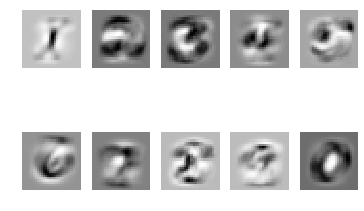

In [20]:
plot_digits(w.T, numcols=5)

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

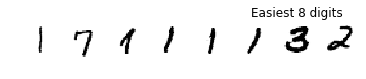

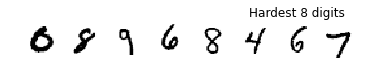

In [21]:
# Ranking by highest probability is the same like ranking log(q(j = t)), therefore we are taking log_qt to make
# it easier from the computational perspective
log_q = x_valid.dot(w) + b

log_qt = np.array([log_q[index, value] for (index,), value in np.ndenumerate(t_valid)]) 
sorted_by_log_qt = np.argsort(log_qt)
easiest = sorted_by_log_qt[-8:]
for i in range(8):
    plt.subplot(1, 8, i)
    plt.axis('off')
    plt.imshow(x_train[easiest[i]].reshape((28, 28)), interpolation='nearest', cmap='Greys')
plt.title('Easiest 8 digits')
plt.show()

hardest = sorted_by_log_qt[:8]
for i in range(8):
    plt.subplot(1, 8, i)
    plt.axis('off')
    plt.imshow(x_train[hardest[i]].reshape((28, 28)), interpolation='nearest', cmap='Greys')
plt.title('Hardest 8 digits')
plt.show()

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

##### Answer: 

$\mathcal{L}^{(n)} = \log q_j - \log Z = \mathbf{w}_j^T \mathbf{h} + b_j - \log Z = \sum_{i=1}^L W_{ij}\sigma(\mathbf{v}_i^T \mathbf{x} + a_i) + b_j - \log Z = \sum_{i=1}^L W_{ij}\sigma(\sum_{k=1}^{784} v_{ki}x_k + a_i) + b_j - \log Z$

$\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$

For $j = t^{(n)}$: $\delta_j^q = 1 - \dfrac{1}{Z}exp(\log q_j)$

For $j \neq t^{(n)}$: $\delta_j^q = -\dfrac{1}{Z}exp(\log q_j)$

$\delta_i^h = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial h_i} = \delta_j^q W_{ij}$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial b_j} = \delta_j^q$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\dfrac{\partial \log q_j}{\partial \log W_{ij}} = \delta_j^q h_i$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial a_i} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} \dfrac{\partial h_i}{\partial (\mathbf{v_i}^T\mathbf{x} + a_i)}  \dfrac{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}{\partial a_i} = \delta_i^h \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)(1 - \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)) = \delta_i^h h_i (1 - h_i)$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial v_{ki}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} \dfrac{\partial h_i}{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}  \dfrac{\partial(\mathbf{v_i}^T\mathbf{x} + a_i)}{\partial a_i} = \delta_i^h \sigma(\mathbf{v_i}^T\mathbf{x} + a_i)(1 - \sigma(\mathbf{v_i}^T\mathbf{x} + a_i))x_k = \delta_i^h h_i(1 - h_i)x_k$

And the answer for questions in the matrix form will be:

1. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{b}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log  \textbf{ q}} \dfrac{\partial \log \textbf{ q}}{\partial \textbf{b}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log \textbf{q}} = \mathbf{\delta}^q $
It's the same because we don't change the way we apply bias $\textbf{b}$, i.e. $\log \textbf{q} = \textbf{W}^T \textbf{h} +\textbf{b} $, and therefore our gradients are equivalent. 
2. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{w}_j} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial \textbf{w}_j}= \mathbf{\delta}^q_j \dfrac{\partial \textbf{w}_j^T \textbf{h} +b_j}{\partial w_j} = \mathbf{\delta}^q_j \textbf{h}$. 
It's almost the equal to the earlier case because we have only changed $\textbf{x}$ to $\textbf{h}$ in the equation for $q_j$, so now it's $\log q_j = \textbf{w}_j^T \textbf{h} +b_j $, and therefore our gradients will be different in the last term, i.e. previously we had $\textbf x$ (in the vectorized version), and now we have $\textbf{h}$ 
3. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial h_i} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} \dfrac{\partial \log q_j}{\partial h_i} = \delta_j^q W_{ij} =\delta_i^h$, so $\rightarrow \dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{h}}=\delta^h$
4. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{W}} = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log \textbf q}\dfrac{\partial \log \textbf q}{\partial \log \textbf W} = \delta^q \textbf h$
5. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{V} } = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log \textbf q}  \dfrac{ \partial \log {\textbf q}}{\partial \textbf h} \dfrac{\partial \textbf h}{\partial \textbf V} = \mathbf{\delta}^h \sigma^{'}(\textbf V^T \textbf x +\textbf a) \textbf x$, where $\sigma^{'}$ indicates a full derivative of the sigmoid function.
6. $\dfrac{\partial \mathcal{L}^{(n)}}{\partial \textbf{a} } = \dfrac{\partial \mathcal{L}^{(n)}}{\partial \log \textbf q}  \dfrac{ \partial \log {\textbf q}}{\partial \textbf h} \dfrac{\partial \textbf h}{\partial \textbf a}=\mathbf{\delta}^h \sigma^{'}(\textbf V^T \textbf x +\textbf a)$


## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

##### Answer: 

We could add regularisation term to the likelihood, i.e. L-2 norm to prevent overfitting. It's known that an inclusion of the L-2 norm to the likelihood function and finding solutions for the parameters (e.g taking derivatives and optimization) is equavalent to MAP solutions with a Guassian prior on the parameters. 

Generally our likelihood would take the form:

$\mathcal{L}^{(n)} = \log q_{t^{(n)}} - \log Z^{(n)} - \frac{\alpha_1}{2} \sum_{v \in V} v^2 -  \frac{\alpha_2}{2} \sum_{w \in W} w^2$

For our MLP implementation later we specify our formula more detaily:

$\mathcal{L}^{(n)} = \log q_j - \log Z - \dfrac{\alpha_1}{2}\sum_{k=1}^{784}\sum_{i=0}^L v_{ki}^2 - \dfrac{\alpha_2}{2} \sum_{i=0}^L\sum_{j=1}^{10} W_{ij}^2 $

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial b_j} = \delta_j^q$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} = \delta_j^q h_i - \alpha_2 W_{ij}$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial a_i} = \delta_i^h h_i (1 - h_i)$

$\dfrac{\partial \mathcal{L}^{(n)}}{\partial v_{ki}} = \delta_i^h h_i (1 - h_i)x_k - \alpha_1 v_{ki}$

<!-- Bishop 5.5.1 Section -->

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer, and code to train the model.

In [9]:
def mlperceptron_gradient(x, t, W, b, V, a, a1=0.001, a2=0.001):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    log_q = h.dot(W) + b

    a = np.max(log_q)
    logZ = a + np.log(np.sum(np.exp(log_q - a)))
    Z = np.exp(logZ) 

    grad_b = -np.exp(log_q) / Z
    grad_b[t] += 1

    grad_W = h[np.newaxis].T.dot(grad_b[np.newaxis]) - a2 * W

    grad_h = W[:,t].dot(grad_b[t])
    grad_a = grad_h * h * (1 - h)

    grad_V = x[np.newaxis].T.dot(grad_a[np.newaxis]) - a1 * V
    return grad_W, grad_b, grad_V, grad_a

def init_mlperceptron_weights(num_of_features, num_of_class, L):
    W = (np.random.random_sample((L, num_of_class)) - 0.5) * 0.001
    b = (np.random.random_sample(num_of_class) - 0.5) * 0.001
    V = (np.random.random_sample((num_of_features, L)) - 0.5) * 0.001
    a = (np.random.random_sample(L) - 0.5) * 0.001
    return W, b, V, a

In [10]:
def sgd_mlperceptron_iter(x_train, t_train, W, b, V, a, a1=0.001, a2=0.001, lr=0.001):
    indexes = np.arange(len(x_train))
    np.random.shuffle(indexes)

    for index in indexes:
        grad_W, grad_b, grad_V, grad_a = mlperceptron_gradient(x_train[index], t_train[index], W, b, V, a, a1, a2)
        W += lr * grad_W
        b += lr * grad_b
        V += lr * grad_V
        a += lr * grad_a

In [15]:
def compute_log_likelihood(x, t, W, b, V, a):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    log_q = h.dot(W) + b

    a = np.max(log_q)
    log_Z = a + np.log(np.sum(np.exp(log_q - a)))

    log_likelihood = np.sum(np.array([log_q[index, value] for (index,), value in np.ndenumerate(t)]) - log_Z)
    return log_likelihood

In [12]:
import time
def train_mlperceptron(W, b, V, a, a1=0.001, a2=0.001, lr=0.001, num_iter=20, cl=True):
    loglik_train = []
    if cl:
        loglik_train.append(compute_log_likelihood(x_train, t_train, W, b, V, a))
    for i in xrange(num_iter):
        t1 = time.time()
        sgd_mlperceptron_iter(x_train, t_train, W, b, V, a, a1, a2, lr)
        print 'dt =', (time.time() - t1)
        if cl:
            loglik_train.append(compute_log_likelihood(x_train, t_train, W, b, V, a))

    return loglik_train

In [16]:
def predict_mlperceptron(W, b, V, a, x):
    h = 1 / (1 + np.exp(-x.dot(V) - a))
    log_q = h.dot(W) + b
    return np.argmax(log_q, axis=1)

We got 91.9% of accuracy on validation set without model selection:

dt = 19.1295800209
dt = 18.5351212025
dt = 17.9935390949
dt = 16.5828309059
dt = 16.5637030602
dt = 16.3944370747
dt = 16.6506800652
dt = 16.6798601151
dt = 16.7105350494
dt = 16.6627151966
dt = 16.6595449448
dt = 16.6239790916
dt = 17.137887001
dt = 16.7975020409
dt = 16.9959731102
dt = 16.5822629929
dt = 16.6360449791
dt = 16.5408799648
dt = 16.59709692
dt = 16.8761200905
training set
0.91354
validation set
0.9193


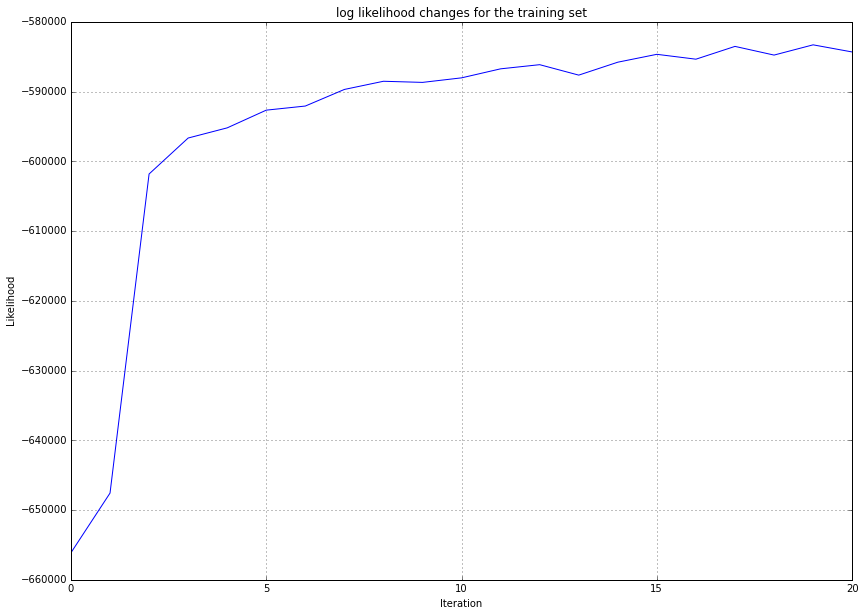

In [18]:
# whole test
# training 
L=50
num_of_features = x_train.shape[1]
num_of_class = 10

W, b, V, a = init_mlperceptron_weights(num_of_features, num_of_class, L)
likelihood = train_mlperceptron(W, b, V, a,num_iter=20)

r = np.arange(len(likelihood))
figure = plt.figure()
figure.set_size_inches((14, 10))
plt.plot(r, likelihood)
plt.title('log likelihood changes for the training set')
plt.ylabel('Likelihood')
plt.xlabel('Iteration')
plt.grid(True)


# training set 
prediction = predict_mlperceptron(W, b, V, a, x_train)
correctness = t_train == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_train))
print 'training set'
print accuracy

# validation set
prediction = predict_mlperceptron(W, b, V, a, x_valid)
correctness = t_valid == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_valid))
print 'validation set'
print accuracy

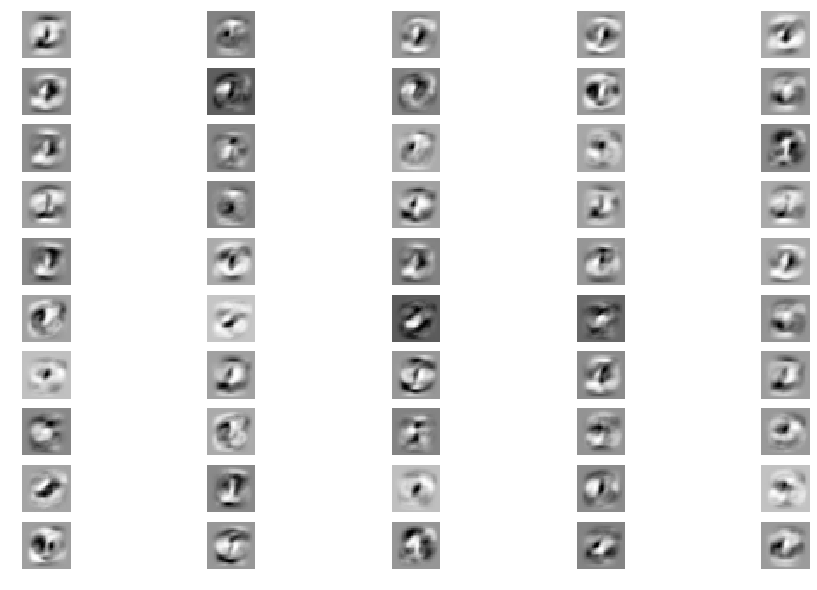

In [19]:
figure = plt.figure()
figure.set_size_inches((16, 10))
plot_digits(V.T, numcols=5)

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.

In [ ]:
# Ignore this cell if you don't want to wait for a century
best_L = 0
best_a1 = 0
best_a2 = 0
best_accuracy = 0

for a1 in [0.001, 0.005, 0.01]:
    for a2 in [0.001, 0.005, 0.01]:
        for L in [150, 200, 250, 300]:
            np.random.seed(0)
            W, b, V, a = init_mlperceptron_weights(num_of_features, num_of_class, L)
            train_mlperceptron(W, b, V, a, a1=a1, a2=a2, num_iter=5, cl=False)
            prediction = predict_mlperceptron(W, b, V, a, x_valid)
            correctness = t_valid == prediction
            accuracy = len(correctness[correctness == True]) / float(len(t_valid))
            print 'L =', L, 'a1 =', a1, 'a2 =', a2, 'accuracy =', accuracy
            if accuracy > best_accuracy:
                best_L = L
                best_a1 = a1
                best_a2 = a2
                best_accuracy = accuracy

print best_a1, best_a2, best_L

dt = 36.1404809952
dt = 36.4526309967
dt = 36.081289053
dt = 35.7838938236
dt = 35.6864190102
L = 150 a1 = 0.001 a2 = 0.001 accuracy = 0.8807
dt = 59.0064771175
dt = 59.9170291424
dt = 59.9129788876
dt = 58.1051089764
dt = 59.1668610573
L = 200 a1 = 0.001 a2 = 0.001 accuracy = 0.8813
dt = 94.0111758709
dt = 91.4698078632
dt = 85.9305830002
dt = 85.7214310169
dt = 91.5173709393
L = 250 a1 = 0.001 a2 = 0.001 accuracy = 0.8806
dt = 115.118833065
dt = 112.193403006
dt = 110.160282135
dt = 110.108178854
dt = 110.097103119
L = 300 a1 = 0.001 a2 = 0.001 accuracy = 0.8789
dt = 34.7444028854
dt = 35.1943128109
dt = 35.2584700584
dt = 35.273624897
dt = 35.2362449169
L = 150 a1 = 0.001 a2 = 0.005 accuracy = 0.8738
dt = 57.7591640949
dt = 57.6998641491
dt = 57.3350760937
dt = 58.3718030453
dt = 57.7873208523
L = 200 a1 = 0.001 a2 = 0.005 accuracy = 0.8779
dt = 85.1471838951
dt = 85.2267768383
dt = 85.265212059
dt = 85.0255630016
dt = 84.4933559895
L = 250 a1 = 0.001 a2 = 0.005 accuracy = 0.8761
dt

In [28]:
np.random.seed(0)
best_a1 = 0.001
best_a2 = 0.001
best_L = 200
W, b, V, a = init_mlperceptron_weights(num_of_features, num_of_class, best_L)
# L = 150 a1 = 0.001 a2 = 0.001 accuracy = 0.8807
# L = 200 a1 = 0.001 a2 = 0.001 accuracy = 0.8813
# L = 250 a1 = 0.001 a2 = 0.001 accuracy = 0.8806
# L = 300 a1 = 0.001 a2 = 0.001 accuracy = 0.8789
# L = 150 a1 = 0.001 a2 = 0.005 accuracy = 0.8738
# L = 200 a1 = 0.001 a2 = 0.005 accuracy = 0.8779
# L = 250 a1 = 0.001 a2 = 0.005 accuracy = 0.8761

train_mlperceptron(W, b, V, a, a1=best_a1, a2=best_a2, num_iter=20, cl=False)

dt = 64.8666241169
dt = 64.7134349346
dt = 64.4661099911
dt = 64.2972989082
dt = 64.8289330006
dt = 64.6778249741
dt = 65.1156840324
dt = 64.2937319279
dt = 64.8534121513
dt = 64.4524497986
dt = 64.1453700066
dt = 64.9153909683
dt = 64.5796968937
dt = 64.261963129
dt = 63.4503080845
dt = 62.8272130489
dt = 63.8530681133
dt = 64.3897378445
dt = 64.5703201294
dt = 64.4503500462


[]

In [39]:
prediction = predict_mlperceptron(W, b, V, a, x_valid)
correctness = t_valid == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_valid))
print accuracy

0.9179


In [30]:
W1 = np.copy(W)
b1 = np.copy(b)
V1 = np.copy(V)
a1 = np.copy(a)
train_mlperceptron(W1, b1, V1, a1, a1=best_a1, a2=best_a2, num_iter=5, cl=False)

dt = 55.5144901276
dt = 55.3634490967
dt = 55.3930630684
dt = 54.1291520596
dt = 54.125690937


[]

In [40]:
prediction = predict_mlperceptron(W1, b1, V1, a1, x_valid)
correctness = t_valid == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_valid))
print accuracy

0.92


In [32]:
W2 = np.copy(W1)
b2 = np.copy(b1)
V2 = np.copy(V1)
a2 = np.copy(a1)
train_mlperceptron(W2, b2, V2, a2, a1=best_a1, a2=best_a2, num_iter=5, cl=False)

dt = 54.5731868744
dt = 55.0300350189
dt = 54.8870930672
dt = 54.5760028362
dt = 54.5074689388


[]

In [41]:
prediction = predict_mlperceptron(W2, b2, V2, a2, x_valid)
correctness = t_valid == prediction
accuracy = len(correctness[correctness == True]) / float(len(t_valid))
print accuracy

0.9205
